# The Graphons of Different Class of Graphs in one Dataset are distinctly different

In [1]:
import torch
torch.__version__

'1.10.1'

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
1
Tesla V100S-PCIE-32GB


In [3]:
from torch_geometric.datasets import TUDataset
import os.path as osp
from gmixup import prepare_dataset_onehot_y
from utils import split_class_graphs
from graphon_estimator import universal_svd, largest_gap
from utils import align_graphs, stat_graph
import random
import matplotlib.pyplot as plt
import matplotlib as mpl

Median num nodes:  17
Finished splitting class graphs
Finished aligning graphs of label  [0. 1.]
Finished aligning graphs of label  [1. 0.]
graphon info: label:[0. 1.]; mean: 0.4060622751712799, shape, (17, 17)
graphon info: label:[1. 0.]; mean: 0.4743252694606781, shape, (17, 17)
Median num nodes:  304
Finished splitting class graphs
Finished aligning graphs of label  [0. 1.]
Finished aligning graphs of label  [1. 0.]
graphon info: label:[0. 1.]; mean: 0.14432887732982635, shape, (15, 15)
graphon info: label:[1. 0.]; mean: 0.158311128616333, shape, (15, 15)
Median num nodes:  10
Finished splitting class graphs
Finished aligning graphs of label  [1. 0. 0.]
Finished aligning graphs of label  [0. 0. 1.]
Finished aligning graphs of label  [0. 1. 0.]
graphon info: label:[1. 0. 0.]; mean: 0.4944722354412079, shape, (12, 12)
graphon info: label:[0. 0. 1.]; mean: 0.5413889288902283, shape, (12, 12)
graphon info: label:[0. 1. 0.]; mean: 0.44858333468437195, shape, (12, 12)


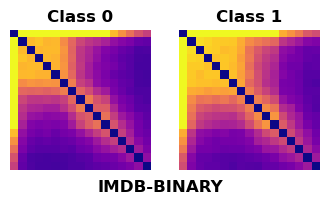

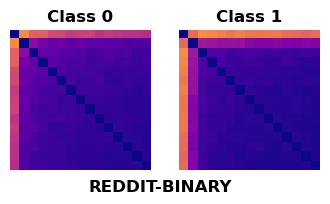

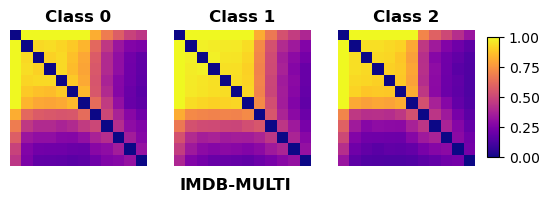

In [4]:
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

dataset_names = ['IMDB-BINARY', 'REDDIT-BINARY', 'IMDB-MULTI']
graphon_sizes = [17, 15, 12]
data_path = './'
align_max_size = 1000

for dataset_name, graphon_size in zip(dataset_names, graphon_sizes):
    path = osp.join(data_path, dataset_name)
    dataset = TUDataset(path, name=dataset_name)
    dataset = list(dataset)

    for graph in dataset:
        graph.y = graph.y.view(-1)

    dataset = prepare_dataset_onehot_y(dataset)
    random.seed(1314)
    random.shuffle(dataset)
    avg_num_nodes, avg_num_edges, avg_density, median_num_nodes, median_num_edges, median_density = stat_graph(
        dataset)
    print('Median num nodes: ', int(median_num_nodes))
    class_graphs = split_class_graphs(dataset)
    print('Finished splitting class graphs')
    fig, ax = plt.subplots(1, len(class_graphs), figsize=(2*len(class_graphs),2), facecolor='w')
    if dataset_name == 'IMDB-MULTI':
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
    graphons = []
    for label, graphs in class_graphs:
        align_graphs_list, normalized_node_degrees, max_num, min_num = align_graphs(
            graphs[:align_max_size], padding=True, N=int(graphon_size))
        print('Finished aligning graphs of label ', label)
        graphon = largest_gap(align_graphs_list, k=graphon_size)
        np.fill_diagonal(graphon, 0)  # Confirmed in correspondence with the author
        graphons.append((label, graphon))
    
    for (label, graphon), axis, i in zip(graphons, ax, range(len(graphons))):
        print(f"graphon info: label:{label}; mean: {graphon.mean()}, shape, {graphon.shape}")
        im = axis.imshow(graphon, vmin=0, vmax=1, cmap=plt.cm.plasma)
        axis.set_title(f"Class {i}", weight="bold")
        axis.axis('off')
    if dataset_name == 'IMDB-MULTI':
        fig.colorbar(im, cax=cbar_ax, orientation='vertical')
    fig.suptitle(dataset_name, y=0.1, weight="bold")
    plt.savefig(f'../fig/{dataset_name}.png', facecolor='white', bbox_inches='tight')